In [2]:
from sigvisa.models.spatial_regression.multi_shared_bcm import MultiSharedBCM, Blocker, sample_synthetic
from sigvisa.models.spatial_regression.local_regression import BCM

from sigvisa.treegp.gp import GPCov, GP, mcov, prior_sample, dgaussian
from sigvisa.utils.fileutils import mkdir_p
import scipy.stats
import scipy.optimize
import time
import os

In [3]:
noise_var=0.01
n = 8000
ntrain = 
lscale=0.5
Xfull, Yfull, cov = sample_synthetic(n=n, noise_var=noise_var, yd=10, lscale=lscale)
X, Y = Xfull[:ntrain,:], Yfull[:ntrain,:]
Xtest, Ytest = Xfull[ntrain:,:], Yfull[ntrain:,:]

In [73]:
#pts = np.linspace(0, 1, 9)[1::2]
#centers = [np.array((xx, yy)) for xx in pts for yy in pts]
centers = [np.array((0.5, 0.5))]

#b = Blocker(centers)
#SX, SY, perm, block_boundaries = b.sort_by_block(X, Y)
#YY = np.dot(SY, SY.T)
SX, SY = X, Y

In [74]:
trivial_boundaries = [(0, SX.shape[0])]
mbcm_full = MultiSharedBCM(SX, Y=SY, block_boundaries=trivial_boundaries, cov=cov, 
                           noise_var=noise_var, kernelized=False, neighbor_threshold=1e-3)



In [12]:
pts = np.linspace(0, 1, 21)[1::2]
centers = [np.array((xx, yy)) for xx in pts for yy in pts]
print len(centers)

100


observation error 0.0358801376684
prediction likelihood true 37.498365068
prediction likelihood obs -18.6514608724


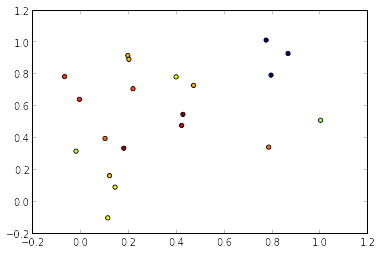

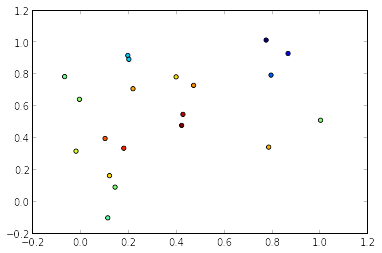

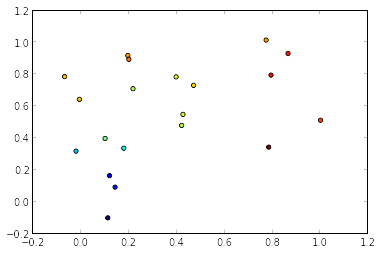

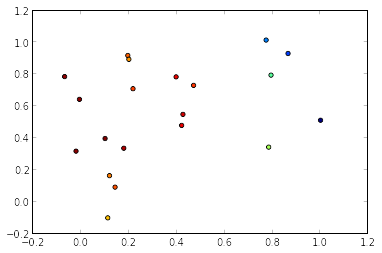

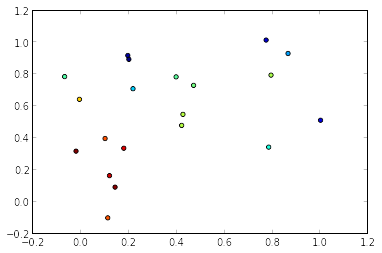

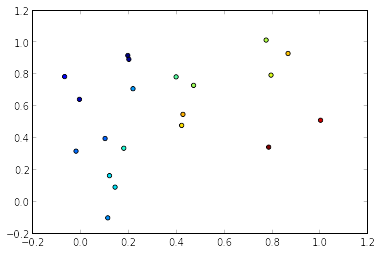

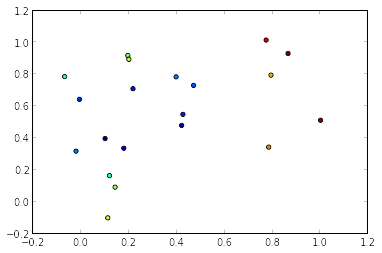

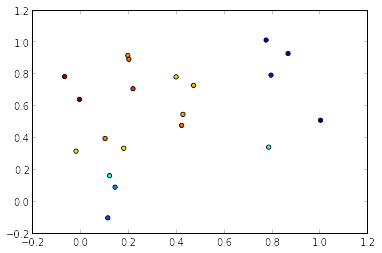

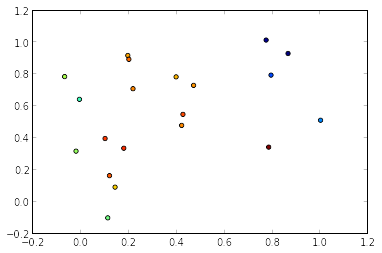

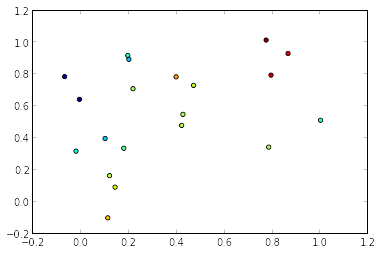

In [35]:
obs_std = 0.05
X_obs = SX + np.random.randn(*X.shape)*obs_std

def x_prior(xx):
    flatobs = X_obs.flatten()
    ll = np.sum([scipy.stats.norm(flatobs[i], scale=obs_std).logpdf(xx[i]) for i in range(len(xx))])
    lderiv = np.array([-(xx[i]-flatobs[i])/(obs_std**2) for i in range(len(xx))]).flatten()
    return ll, lderiv

def mean_abs_err(x):
    return np.mean(np.abs(x - X.flatten()))

def prediction_error_gp(x):
    XX = x.reshape(X_obs.shape)
    ll = 0
    for y, yt in zip(Y.T, Ytest.T):
        gp = GP(X=XX, y=y, cov_main=cov, noise_var=noise_var, 
                sort_events=False, sparse_invert=False)
        pred_means = gp.predict(Xtest)
        pred_cov = gp.covariance(Xtest, include_obs=True)
        lly = scipy.stats.multivariate_normal(pred_means, pred_cov).logpdf(yt)
        ll += lly
    return ll

def prediction_error_bcm(x):
    XX = x.reshape(X_obs.shape)
    ll = 0
    for y, yt in zip(Y.T, Ytest.T):
        bcm = BCM(block_centers=centers, cov_block_params = [(noise_var, 1.0, lscale, lscale)], 
                  X=XX, y=y, test_cov=cov)
        m, c = bcm.predict_dist(Xtest, noise_var=noise_var)
        lly = scipy.stats.multivariate_normal(m, c).logpdf(yt)
        ll += lly
    return ll

def vis(X, y):
    for i in range(y.shape[1]):
        figure()
        scatter(X[:, 0], X[:, 1], c=y[:,i], cmap="jet")
        
print "observation error", mean_abs_err(X_obs.flatten())

print "prediction likelihood true", prediction_error_bcm(X.flatten())
print "prediction likelihood obs", prediction_error_bcm(X_obs.flatten())


vis(X_obs, SY)

In [59]:
llgrad_bcm = lambda mbcm : mbcm.llgrad(local=True, grad_X=True)
llgrad_lgp = lambda mbcm : mbcm.llgrad_blocked(grad_X=True)
llgrad_gp = lambda mbcm : mbcm.llgrad(grad_X=True)

def do_optimization(llgrad, mbcm, run_name, X0):

    x0 = X0.flatten()

    sstep = [0,]
    d = "/home/dmoore/python/sigvisa/experiments/bcmopt/" + run_name
    mkdir_p(d)
    
    f_log = open(os.path.join(d, "log.txt"), 'w')
    t0 = time.time()
    
    def lgpllgrad(xx):
        XX = xx.reshape(X0.shape)
        mbcm.update_X(XX)
        #ll, grad = mbcm.llgrad(local=True, parallel=True, grad_X=True)
        ll, grad = llgrad(mbcm)
        grad = grad.flatten()

        prior_ll, prior_grad = x_prior(xx)
        ll += prior_ll
        grad += prior_grad
        
        print "%d %.2f %.2f" % (sstep[0], time.time()-t0, ll)
        f_log.write("%d %.2f %.2f\n" % (sstep[0], time.time()-t0, ll))
        f_log.flush()
        
        np.save(os.path.join(d, "step_%05d" % sstep[0]), XX)        
        sstep[0] += 1  
        
        return -ll, -grad

    bounds = [(0.0, 1.0),]*len(x0)
    r = scipy.optimize.minimize(lgpllgrad, x0, jac=True)
    t1 = time.time()
    
    np.save(os.path.join(d, "step_final"), r.x.reshape(X0.shape))
    
    f_log.close()
    
    with open(os.path.join(d, "results.txt"), 'w') as f:
        f.write("optimized in %.2f seconds\n" % (t1-t0))
        f.write("MAD error %.04f to %.04f\n" % (mean_abs_err(x0), mean_abs_err(r.x)))
        f.write("GP predictive likelihood %.3f to %.3f\n" % (prediction_error_gp(x0), prediction_error_gp(X.flatten())))
        f.write("BCM predictive likelihood %.3f to %.3f\n" % (prediction_error_bcm(x0), prediction_error_bcm(X.flatten())))
        f.write("\n\nresult:\n")
        f.write(str(r))

    

In [60]:
do_optimization(llgrad_gp, mbcm_full, "test_small_gp", X_obs)

0 0.07 -53.38
1 0.17 -53.38
2 0.31 -143367382.33
3 0.40 -1666.55
4 0.51 -105.13
5 0.63 0.53
6 0.74 -88.49
7 0.89 16.64
8 1.09 -1.78
9 1.21 22.77
10 1.36 9.66
11 1.45 24.62
12 1.68 24.40
13 1.90 25.59
14 2.05 25.02
15 2.28 25.98
16 2.51 26.29
17 2.74 26.12
18 2.95 26.41
19 3.15 26.41
20 3.22 26.48
21 3.43 26.40
22 3.58 26.50
23 3.70 26.51
24 3.80 26.52
25 3.99 26.52
26 4.08 26.52
27 4.25 26.53
28 4.38 26.53
29 4.53 26.54
30 4.62 26.56
31 4.85 26.59
32 5.01 26.66
33 5.11 26.86
34 5.32 27.31
35 5.49 28.00
36 5.68 28.65
37 5.85 29.07
38 6.08 28.71
39 6.27 29.22
40 6.48 29.07
41 6.71 29.27
42 6.92 29.15
43 7.05 29.28
44 7.14 29.28
45 7.25 29.29
46 7.48 29.28
47 7.71 29.29
48 7.92 29.29
49 8.11 29.30
50 8.31 29.31
51 8.45 29.36
52 8.57 29.46
53 8.69 29.63
54 8.92 29.26
55 9.15 29.67
56 9.25 29.09
57 9.39 29.67
58 9.61 29.67
59 9.83 29.68
60 9.96 29.71
61 10.13 29.79
62 10.33 29.19
63 10.46 29.80
64 10.56 29.77
65 10.62 29.80
66 10.74 29.80
67 10.97 29.81
68 11.15 29.85
69 11.21 29.41
70 11.4

In [28]:
#print mbcm.llgrad(grad_X=True)

import time
t0 = time.time()
l, g = mbcmk.llgrad(grad_X=True, local=False)
t1 = time.time()
ll, gl = mbcmk.llgrad(grad_X=True, local=True)
t2 = time.time()
lp, gp = mbcmk.llgrad(grad_X=True, parallel=True, local=False)
t3 = time.time()
lpl, gpl = mbcmk.llgrad(grad_X=True, parallel=True, local=True)
t4 = time.time()
print ll-l
print ll, l, lp, lpl
print t1-t0, t2-t1, t3-t2, t4-t3


0.00513938226231
-18.0302250109 -18.0353643932 -18.0353643932 -18.0302250109
0.494525909424 0.155521154404 0.410672903061 0.322986125946


In [29]:
#print mbcm.llgrad(grad_X=True)

import time
t0 = time.time()
l, g = mbcm.llgrad(grad_X=True, local=False)
t1 = time.time()
ll, gl = mbcm.llgrad(grad_X=True, local=True)
t2 = time.time()
lp, gp = mbcm.llgrad(grad_X=True, parallel=True, local=False)
t3 = time.time()
lpl, gpl = mbcm.llgrad(grad_X=True, parallel=True, local=True)
t4 = time.time()
print ll-l
print ll, l, lp, lpl
print t1-t0, t2-t1, t3-t2, t4-t3


0.0051393822605
-18.0302250109 -18.0353643932 -18.0353643932 -18.0302250109
0.684731960297 0.210592985153 0.268989086151 0.125826835632


In [11]:
unaries = [mbcm.llgrad_unary(i, grad_X=True) for i in range(mbcm.n_blocks)]
unary_lls, unary_grads = zip(*unaries)
print unary_grads

(array([[  3.96778201e+02,   1.90332959e+02],
       [ -9.39521141e+01,   6.82336549e-01],
       [ -2.88786142e+02,   4.97049747e+01],
       [  1.46224649e+02,   4.08451856e+02],
       [  1.02764959e+02,   1.17451716e+01],
       [ -2.67352088e+01,  -5.70612744e+01],
       [ -1.46210024e+02,   2.80372572e+02],
       [  1.26232795e+02,  -8.74660457e+01],
       [ -2.38314026e+02,  -4.84557484e+02],
       [ -1.13486779e+02,  -4.79723503e+00],
       [  1.78697390e+02,  -4.00848534e+00],
       [ -1.66220117e+02,   1.35212542e+02],
       [ -5.95530110e+02,  -3.28016700e+02],
       [ -9.44811537e+01,   1.37684816e+02],
       [ -1.61187891e+02,  -2.11354918e+02],
       [  1.60334907e+01,  -1.36423416e+02],
       [ -6.59390780e+01,   9.95632784e+01],
       [  1.12011852e+02,  -1.06951224e+01],
       [  3.40118613e+02,   4.25610253e+01],
       [ -3.61328036e+02,  -3.16984625e+02],
       [  1.95608183e+02,   1.21041637e+02],
       [ -4.40056061e+01,  -2.24046122e+02],
       [ 

In [20]:
i_start, i_end = mbcm.block_boundaries[0]
bYY = mbcmk.YY[i_start:i_end, i_start:i_end]
bY = mbcm.Y[i_start:i_end]
bYYb = np.dot(bY, bY.T)


[[  9.14443265e+00   8.44102008e-01   3.91799597e+00   6.28068437e+00
    3.64102719e+00  -7.30117297e+00  -2.97623292e-01   2.96617300e-01
    1.88225239e+00  -7.80582038e+00   8.13418558e+00   7.51104787e+00
    8.92972963e+00   1.73750691e+00   3.68731335e+00   1.79294619e+00
   -4.81260878e+00  -7.61313645e+00   6.03389688e+00   7.26791758e-01
    1.98230811e+00  -1.31276256e+00  -5.70767849e+00   2.70162004e+00
    8.45401778e+00  -3.54858627e-01   1.45962069e+00]
 [  8.44102008e-01   3.93386553e+00  -2.06310997e+00   3.05337489e+00
   -3.11477036e+00   3.35026814e+00  -3.18305582e-01  -1.19371779e+00
    4.08435562e-01   2.09192871e+00   2.97936822e+00   2.25140637e+00
   -1.26233832e-01  -3.26096975e+00   2.64875466e+00   7.15960095e-01
    4.40023485e+00   4.01820961e+00  -1.13453791e+00  -1.27529229e-01
    1.34244960e+00  -1.88160468e+00   4.41623292e+00   3.70283249e+00
    1.45784285e+00   3.92033574e+00  -2.56013117e-01]
 [  3.91799597e+00  -2.06310997e+00   9.87796774e+00

In [30]:
from sigvisa.models.spatial_regression.local_regression import LocalGPs, BCM, MultiGPLVM

lscale=0.1
mlgps = MultiGPLVM(X=SX, Y=SY, cov_block_params = np.array(([noise_var, 1.0, lscale, lscale],)), 
                   bcm=True, block_centers=centers, test_cov=cov)

In [31]:
print mlgps.likelihood()


-18.0356076335


In [14]:
print mlgps.lgps[0].gps[0].log_likelihood()
print mlgps.lgps[0].gps[0].X

-7.44073098458
[[ 0.14675589  0.09233859]
 [ 0.14038694  0.19810149]
 [ 0.08504421  0.03905478]
 [ 0.17234051  0.13713575]
 [ 0.01988013  0.02621099]
 [ 0.02830649  0.24621107]
 [ 0.05991769  0.12134346]
 [ 0.04455188  0.10749413]
 [ 0.15679139  0.0185762 ]
 [ 0.01395157  0.23436209]
 [ 0.17395567  0.12632952]
 [ 0.23366614  0.10196726]
 [ 0.14342305  0.0783869 ]
 [ 0.01833264  0.066725  ]
 [ 0.14555823  0.15773007]
 [ 0.24985068  0.17343017]
 [ 0.08748221  0.22730974]
 [ 0.0569644   0.22881367]
 [ 0.0935771   0.06537172]
 [ 0.13766274  0.01088873]
 [ 0.21411214  0.19894792]
 [ 0.02662788  0.11092037]
 [ 0.08052953  0.23170231]
 [ 0.15983365  0.20260213]
 [ 0.20645406  0.07618881]
 [ 0.12076718  0.22028399]
 [ 0.1443154   0.01409229]]


In [15]:
print mbcm.llgrad_unary(0)
i_start, i_end = mbcm.block_boundaries[0]
print mbcm.X[i_start:i_end, :]

(-33.180889277311842, array([], dtype=float64))
[[  4.17022005e-01   7.20324493e-01]
 [  1.14374817e-04   3.02332573e-01]
 [  1.46755891e-01   9.23385948e-02]
 [  1.86260211e-01   3.45560727e-01]
 [  3.96767474e-01   5.38816734e-01]
 [  4.19194514e-01   6.85219500e-01]
 [  2.04452250e-01   8.78117436e-01]
 [  2.73875932e-02   6.70467510e-01]
 [  4.17304802e-01   5.58689828e-01]
 [  1.40386939e-01   1.98101489e-01]
 [  8.00744569e-01   9.68261576e-01]
 [  3.13424178e-01   6.92322616e-01]
 [  8.76389152e-01   8.94606664e-01]
 [  8.50442114e-02   3.90547832e-02]
 [  1.69830420e-01   8.78142503e-01]
 [  9.83468338e-02   4.21107625e-01]
 [  9.57889530e-01   5.33165285e-01]
 [  6.91877114e-01   3.15515631e-01]
 [  6.86500928e-01   8.34625672e-01]
 [  1.82882773e-02   7.50144315e-01]
 [  9.88861089e-01   7.48165654e-01]
 [  2.80443992e-01   7.89279328e-01]
 [  1.03226007e-01   4.47893526e-01]
 [  9.08595503e-01   2.93614148e-01]
 [  2.87775339e-01   1.30028572e-01]
 [  1.93669579e-02   6.7883

In [11]:
ll = 0
def ll(X, Y):
    KK = mcov(X, cov, noise_var) 
    rv = scipy.stats.multivariate_normal(cov=KK)
    ll = 0
    for y in Y.T:
        ll1 = rv.logpdf(y)
        ll += ll1
    return ll

X0 = X_blocks[0]
x0  = X0.flatten()
def llg(xx):
    X = xx.reshape(X0.shape)
    return ll(X, Y_blocks[0])

print scipy.optimize.approx_fprime(x0, llg, 1e-8)

[  3.96777715e+02   1.90332372e+02  -9.39526686e+01   6.81998813e-01
  -2.88786495e+02   4.97046457e+01   1.46224305e+02   4.08451234e+02
   1.02764888e+02   1.17450512e+01  -2.67354878e+01  -5.70615626e+01
  -1.46210343e+02   2.80372002e+02   1.26232220e+02  -8.74668288e+01
  -2.38314573e+02  -4.84558332e+02  -1.13487114e+02  -4.79737565e+00
   1.78696973e+02  -4.00912938e+00  -1.66220252e+02   1.35212339e+02
  -5.95530588e+02  -3.28017396e+02  -9.44813848e+01   1.37684682e+02
  -1.61188302e+02  -2.11355164e+02   1.60333329e+01  -1.36423591e+02
  -6.59401422e+01   9.95629264e+01   1.12011499e+02  -1.06953408e+01
   3.40118142e+02   4.25605364e+01  -3.61328686e+02  -3.16985508e+02
   1.95608011e+02   1.21041381e+02  -4.40058940e+01  -2.24046485e+02
  -2.13465742e+02  -2.02001218e+02  -6.87965036e+02   3.59269734e+01
   7.96373641e+01  -2.64447947e+02   8.61101843e+02   1.27557345e+02
   7.42394725e+02   6.91021022e+02]


In [32]:
XX = X_blocks[0]
YY = Y_blocks[0][:, 0:1]
n, dx = XX.shape
dy = YY.shape[1]

K = mcov(XX, cov, noise_var)
prec = np.linalg.inv(K)
Alpha = np.dot(prec, YY)

ll = -.5 * np.sum(YY*Alpha)
ll += -.5 * dy * np.linalg.slogdet(K)[1]
ll += -.5 * dy * n * np.log(2*np.pi)

llgrad = np.zeros((n, dx))
for p in range(n):
    for i in range(dx):
        dll = 0
        dcv = mbcm.dKdx(XX, p, i, return_vec=True)
        #t1 = -np.outer(prec[p,:], dcv)
        #t1[:, p] = -np.dot(prec, dcv)
        #dll_dcov = .5*ny*np.trace(t1)

        dll_dcov = -dy * np.dot(prec[p,:], dcv)
        
        
        for j in range(dy):
            alpha = Alpha[:,j]
            dK_alpha = dcv * alpha[p]
            dK_alpha[p] = np.dot(dcv, alpha)
            dll_dcov = .5*np.dot(alpha, dK_alpha)
            dll += dll_dcov
            
        llgrad[p, i] = dll_dcov
        
print llgrad

[[  3.3398819   -3.49178491]
 [  5.55437133   6.24502219]
 [  6.00328332  14.51406571]
 [ -9.14623588  -3.4393161 ]
 [  8.04056792  23.25758416]
 [ -2.32176946 -44.14360124]
 [-11.5132134  -12.00542594]
 [ -4.40823803   6.30854935]
 [-23.74392705   1.75693795]
 [ 26.24540291  23.03947336]
 [ -8.42059923   1.12571558]
 [-20.98135396  -2.30624784]
 [ -1.18536019   6.9502817 ]
 [ 11.4355909   -0.35791765]
 [ 13.92375319   1.97622617]
 [-20.26493014   1.22194038]
 [ -1.26437493   0.7055501 ]
 [  7.63525814  22.74111107]
 [  2.28300849  -7.39490067]
 [ 14.39360812  18.23213263]
 [ -4.29422879 -16.49873024]
 [ 27.53431395 -16.92219381]
 [ -2.8534925  -15.26940264]
 [ -8.82685294  -9.18359181]
 [ -2.09211009  15.29371542]
 [ -6.85927946 -16.98530375]
 [  1.78692589   4.63011082]]


In [33]:
X0 = X_blocks[0]
x0 = X0.flatten()
def logdet(xx):
    XX = xx.reshape(X0.shape)
    K = mcov(XX, cov, noise_var)
    return -.5 * dy * np.linalg.slogdet(K)[1]

print scipy.optimize.approx_fprime(x0, logdet, 1e-6)


[  3.33977664  -3.49185975   5.55414833   6.24500116   6.00334491
  14.51408001  -9.14646315  -3.43937771   8.04052881  23.25776216
  -2.32177574 -44.14338694 -11.51310611 -12.00558865  -4.40832011
   6.30825488 -23.7441649    1.75644038  26.24542174  23.03943562
  -8.42077915   1.125691   -20.98132124  -2.30616974  -1.18537568
   6.9501728   11.43531325  -0.35753906  13.92380109   1.97640155
 -20.26488703   1.22204624  -1.26446803   0.70391278   7.63547642
  22.74062889   2.28305754  -7.39480518  14.39339142  18.23110353
  -4.29403268 -16.49891811  27.53427741 -16.92222444  -2.85359613
 -15.27109209  -8.82669146  -9.18397459  -2.09197502  15.29378217
  -6.85928764 -16.98614582   1.78629197   4.62884647]


[-0.14868991  2.45489368  0.14641511 -2.44564378]


In [21]:
print  -.5 * np.sum(YY*Alpha)
print -.5 * np.dot(YY.T, np.dot(prec, YY))

-12.5160292931
[[-12.51602929]]
2
